<a href="https://colab.research.google.com/github/PPatrickGU/ROB313/blob/main/ROB313_DeepLearning_Exercice1_Zheyi_Dajing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROB313 - TP2 : Deep Learning** 

## **Exercise 1 : Mnist classification with Pytorch**

*Author: Zheyi SHEN & Dajing GU*


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import numpy as np
import os
import torchvision
import matplotlib.pyplot as plt
from torchvision.models.resnet import resnet18
from torchsummary import summary

### **Q1 Analysis of the script given by the prof**

In [ ]:
dtype = torch.float
DEVICE = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=DEVICE, dtype=dtype)
y = torch.randn(N, D_out, device=DEVICE, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=DEVICE, dtype=dtype)
w2 = torch.randn(H, D_out, device=DEVICE, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


99 876.8778686523438
199 7.913716793060303
299 0.13472424447536469
399 0.0034938130993396044
499 0.0002752822474576533


### **Q2 Implementaion of a simple neural net architecture for the Minst hand-writing dataset**

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.FC1 = nn.Linear(784, 128)
    self.FC2 = nn.Linear(128, 10)
  def forward(self, x):
    x = torch.sigmoid(self.FC1(x.view(-1,784)))
    x = self.FC2(x.view(-1,128))
    # print(x)
    return x

In [ ]:
n = Net()
print(n)

Net(
  (FC1): Linear(in_features=784, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=10, bias=True)
)


**Import MINIST handwriting Dataset**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5), std=(0.5))])
train_set = datasets.MNIST(root = "./data/", transform = transform, train = True, download = True)
test_set = datasets.MNIST(root = "./data/", transform = transform, train = False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

[3, 1, 7, 1, 4, 2, 4, 2]
[3, 6, 2, 8, 1, 6, 5, 2]
[9, 5, 0, 2, 2, 5, 4, 3]
[7, 7, 6, 2, 2, 1, 8, 3]
[8, 5, 3, 8, 4, 9, 7, 9]
[0, 8, 3, 9, 2, 0, 8, 4]
[2, 9, 9, 5, 6, 0, 8, 2]
[3, 4, 6, 7, 4, 4, 1, 0]


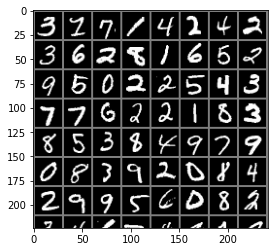

In [ ]:
images, labels = iter(train_loader).next()
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
std = [0.5]
mean = [0.5]
img = img*std+mean
for i in range(64//8):
  print([labels[8*i+j].tolist() for j in range(8)])
plt.imshow(img[:28*8])

In [ ]:
BATCH_SIZE = 512
EPOCHS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()
        output = model(data)
        # loss = criterion(output, target)
        loss = criterion(output, target)
        
        loss.backward()
        # Perform the training parameters update
        optimizer.step()

        if (batch_idx + 1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx , len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss =0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.max(1, keepdim = True)[1] # get the index whose value is the biggest
            correct += pred.eq(target.view_as(pred)).sum().item()

    
    test_loss /= len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n".format(
        test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)
            ))

In [ ]:
model = Net()
model= model.to(DEVICE)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-3, momentum = 0.9) #regularization: weight_decay

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model,  DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [29/118 (25%)]	Loss: 2.117381
Train Epoch: 1 [59/118 (50%)]	Loss: 1.760209
Train Epoch: 1 [89/118 (75%)]	Loss: 1.356727

Test set: Average loss: 0.0021, Accuracy: 7966/10000 (80%) 

Train Epoch: 2 [29/118 (25%)]	Loss: 0.919011
Train Epoch: 2 [59/118 (50%)]	Loss: 0.722206
Train Epoch: 2 [89/118 (75%)]	Loss: 0.670942

Test set: Average loss: 0.0012, Accuracy: 8647/10000 (86%) 



### **Q3 Adding summaries to save the results**

In [ ]:
# build a folder to save the summaries
writer = SummaryWriter('runs/MNIST_TEST')
# n_iter = iterations step
for n_iter in range(100):
  writer.add_scalar('Loss/train', np.random.random(), n_iter)
  writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
writer.close()
print(writer)

### **Q4 Convolutional neural network (CNN: Resnet $18^2$)**

**Manual Implementation de ResNet18 (change the number of channel in self.pre to cater to the datset)**

In [ ]:
# Definition of ResBlock
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
        super(ResBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

# Definition of ResNet
class ResNet(nn.Module):
    def __init__(self,num_classes = 10):
        super(ResNet,self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        shortcut = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
            nn.BatchNorm2d(outchannel))
        layers = []
        layers.append(ResBlock(inchannel, outchannel, stride, shortcut))
        for i in range(1, block_num):
            layers.append(ResBlock(outchannel, outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.pre(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out


In [ ]:
model = ResNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-3, momentum = 0.9) #regularization: weight_decay

**Import MINIST handwriting Dataset (Resize the images to shape (224,224) to cater to the need of ResNet)**

In [ ]:
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5), std=(0.5))])
train_set = datasets.MNIST(root = "./data/", transform = transform, train = True, download = True)
test_set = datasets.MNIST(root = "./data/", transform = transform, train = False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model,  DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [29/118 (25%)]	Loss: 0.302555
Train Epoch: 1 [59/118 (50%)]	Loss: 0.112476
Train Epoch: 1 [89/118 (75%)]	Loss: 0.095630

Test set: Average loss: 0.0005, Accuracy: 9104/10000 (91%) 

Train Epoch: 2 [29/118 (25%)]	Loss: 0.041595
Train Epoch: 2 [59/118 (50%)]	Loss: 0.028539
Train Epoch: 2 [89/118 (75%)]	Loss: 0.027480

Test set: Average loss: 0.0001, Accuracy: 9776/10000 (98%) 




### **Q5 Use of Optuna to find the best hyperparameters**

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective(trial):

    model = ResNet().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    lr = trial.suggest_loguniform("lr", 1e-3, 10)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-3, 1)

    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum = 0.9)

    # Training of the model.
    
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # # Limiting training data for faster epochs.
            # if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #     break
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                # if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                #     break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        # accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        accuracy = correct / len(test_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
search_space = {"lr": [1, 0.1, 0.01, 0.001], "weight_decay": [0.1, 0.01, 0.001]}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction="maximize")
study.optimize(objective, n_trials=12)


[I 2020-12-10 19:43:23,019] A new study created in memory with name: no-name-28945ebf-1e4d-43c4-bb4c-4c68020b0c7d
